In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from darkmod.deformation import straight_edge_dislocation

fontsize = 22  # General font size for all text
ticksize = 22  # tick size
plt.rcParams["font.size"] = fontsize
plt.rcParams["xtick.labelsize"] = ticksize
plt.rcParams["ytick.labelsize"] = ticksize

In [ ]:
xg = np.linspace(-1, 1, 64)
X, Y, Z = np.meshgrid(xg, xg, xg, indexing="ij")

F = straight_edge_dislocation((X, Y, Z))

beta_1 = F.copy().reshape(-1, 3, 3) - np.eye(3)
beta_1 = beta_1.reshape(X.shape + (3, 3))

H = np.linalg.inv(F.reshape(-1, 3, 3).transpose(0, 2, 1)) - np.eye(3)
beta_2 = -H.transpose(0, 2, 1)
beta_2 = beta_2.reshape(X.shape + (3, 3))

residual = beta_1 - beta_2

In [98]:
print(np.max(residual) ), print(np.min(residual) )

0.001054729218649464
-0.0010324418283299552


(None, None)

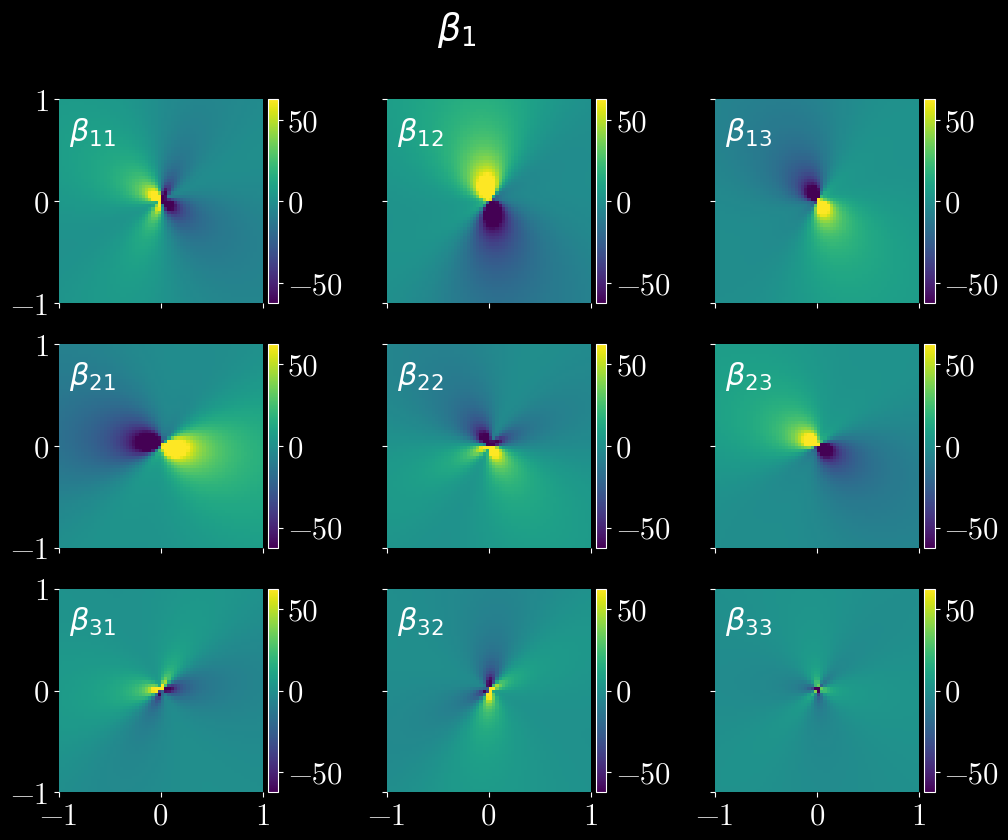

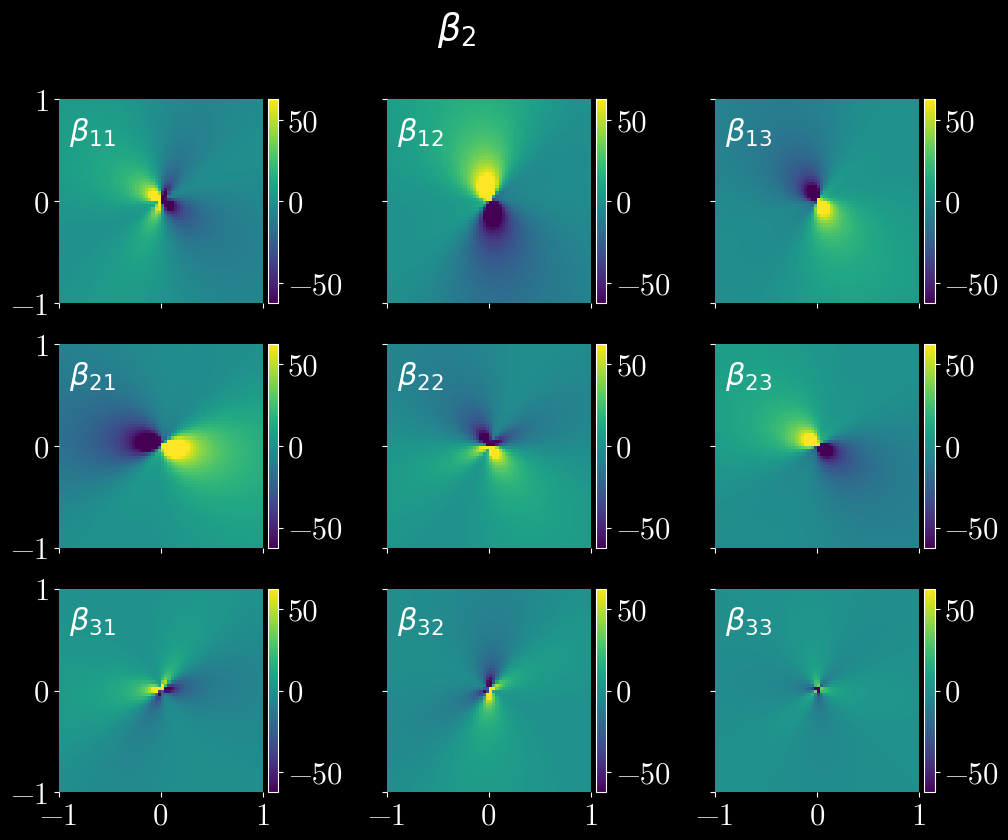

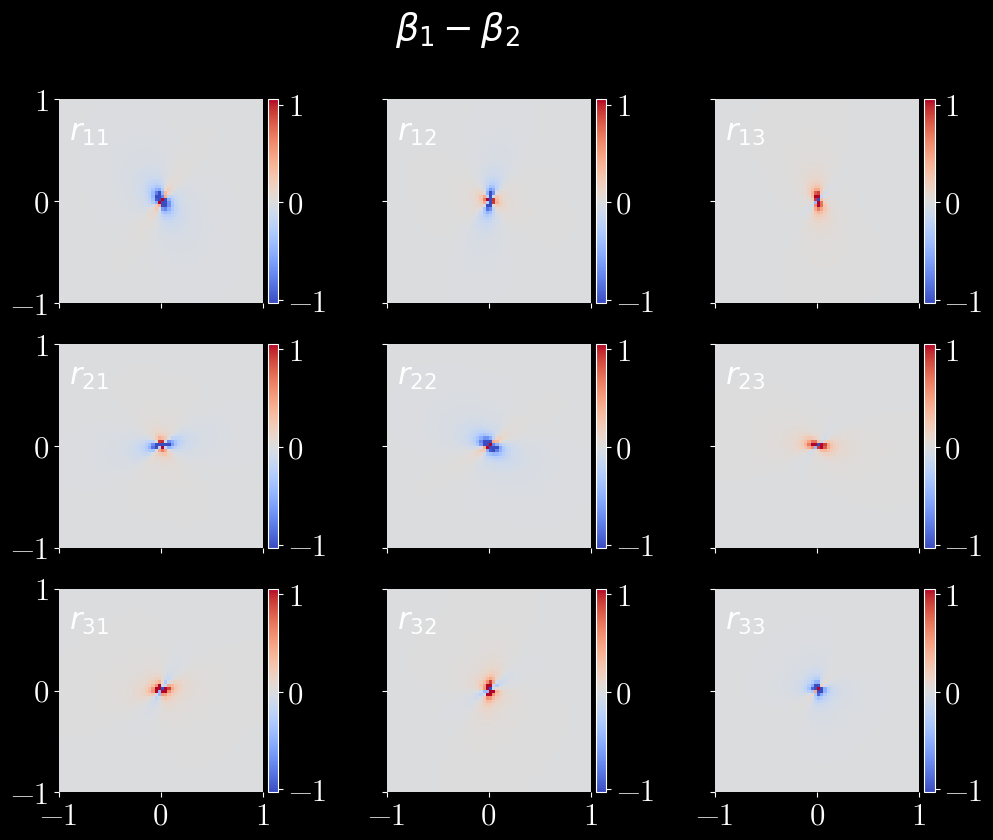

In [99]:
plt.style.use("dark_background")
vmin = np.min(beta_1) * 1e4 * 0.1
vmax = np.max(beta_1) * 1e4 * 0.1

titles = ["$\\beta_1$", "$\\beta_2$", "$\\beta_1 - \\beta_2$"]
cmaps = ["viridis", "viridis", "coolwarm"]
vmins = [vmin, vmin, np.min(residual) * 0.1 * 1e4]
vmaxs = [vmax, vmax, np.max(residual) * 0.1 * 1e4]

all_annotations = ( 
['$\\beta_{11}$',  '$\\beta_{12}$', '$\\beta_{13}$', '$\\beta_{21}$', '$\\beta_{22}$', '$\\beta_{23}$', '$\\beta_{31}$', '$\\beta_{32}$', '$\\beta_{33}$'],
 ['$\\beta_{11}$',  '$\\beta_{12}$', '$\\beta_{13}$', '$\\beta_{21}$', '$\\beta_{22}$', '$\\beta_{23}$', '$\\beta_{31}$', '$\\beta_{32}$', '$\\beta_{33}$'],
['$r_{11}$', '$r_{12}$', '$r_{13}$', '$r_{21}$', '$r_{22}$', '$r_{23}$', '$r_{31}$', '$r_{32}$', '$r_{33}$']
)

for field, cm, tit, vmin, vmax, annotations in zip(
    (beta_1, beta_2, residual), cmaps, titles, vmins, vmaxs, all_annotations
):
    fig, ax = plt.subplots(3, 3, figsize=(12, 9), sharex=True, sharey=True)
    fig.suptitle(tit)
    k=0
    for i in range(3):
        for j in range(3):
            
            im = ax[i, j].imshow(
                field[:, :, field.shape[2] // 2, i, j] * 1e4,
                origin="lower",
                extent=(-1, 1, -1, 1),
                vmin=vmin,
                vmax=vmax,
                cmap=cm,
            )
            ax[i,j].annotate(annotations[k], (-0.9,0.6), color='white', fontsize=22)
            k+=1
            fig.colorbar(im, ax=ax[i, j], fraction=0.046, pad=0.02)
    for a in ax.flatten():
        for spine in a.spines.values():
            spine.set_visible(False)
    plt.show()

In [183]:
xg = np.linspace(-0.2, 0.2, 256)
zg = np.array( [0])
Xgrid, Ygrid, Zgrid = np.meshgrid(xg, xg, zg, indexing="ij")
err = []




def _disp_grad(x_d, y_d, bmag, nu):
    """displacement gradient field around a single of edge dislocations"""
    x_d2, y_d2 = x_d * x_d, y_d * y_d
    epsilon = 1e-10  # avoid zero division
    t0 = x_d2 + y_d2 + epsilon
    t1 = 2 * nu * t0
    t2 = 3 * x_d2 + y_d2
    factor = bmag / (4 * np.pi * (1 - nu) * t0**2)
    dux_dx = -y_d * factor * (t2 - t1)
    dux_dy = x_d * factor * (t2 - t1)
    duy_dx = -x_d * factor * (x_d2 + 3 * y_d2 - t1)
    # duy_dy = y_d * factor * (x_d2 - y_d2 - t1)
    duy_dy = y_d * factor * (x_d2 - y_d2 + t1)
    return dux_dx, dux_dy, duy_dx, duy_dy


nu=0.334
b=2.86 * np.array([1, -1, 0]) * 1e-4
n=np.array([1, 1, -1])
t=np.array([1, 1, 2])
U=np.eye(3)
coord = (Xgrid,Ygrid,Zgrid)


x0 = (np.random.rand(300, 3)-0.5)*0.05

# dislocation system basis matrix
U_d = np.array([b, n, t]).T
U_d = U_d / np.linalg.norm(U_d, axis=0)

bmag = np.linalg.norm(b)

# dislocation system voxel cooridnates.
X, Y, Z = (U_d.T @ U.T) @ np.array([c.flatten() for c in coord])

F_d = np.zeros((len(X), 3, 3))

x0_d = (U_d.T @ U.T) @ np.array(x0).T
mederr=[]
meanerr=[]
for i in range(3):
    F_d[:, i, i] += 1

for i in range(x0_d.shape[1]):
    x, y, _ = x0_d[:, i]
    dux_dx, dux_dy, duy_dx, duy_dy = _disp_grad((X - x), (Y - y), bmag, nu)
    F_d[:, 0, 0] += dux_dx
    F_d[:, 0, 1] += dux_dy
    F_d[:, 1, 0] += duy_dx
    F_d[:, 1, 1] += duy_dy

    F_g = ((U @ U_d) @ F_d @ (U_d.T @ U.T)).reshape((*coord[0].shape, 3, 3))

    beta_1 = F_g.copy().reshape(-1, 3, 3) - np.eye(3)
    beta_1 = beta_1.reshape(Xgrid.shape + (3, 3))

    H = np.linalg.inv(F_g.reshape(-1, 3, 3).transpose(0, 2, 1)) - np.eye(3)
    beta_2 = -H.transpose(0, 2, 1)
    beta_2 = beta_2.reshape(Xgrid.shape + (3, 3))

    residual = beta_1 - beta_2

    err.append(np.max(np.abs(residual[0:10,0:10])))
    mederr.append(np.median(np.abs(residual[0:10,0:10])))
    meanerr.append(np.mean(np.abs(residual[0:10,0:10])))

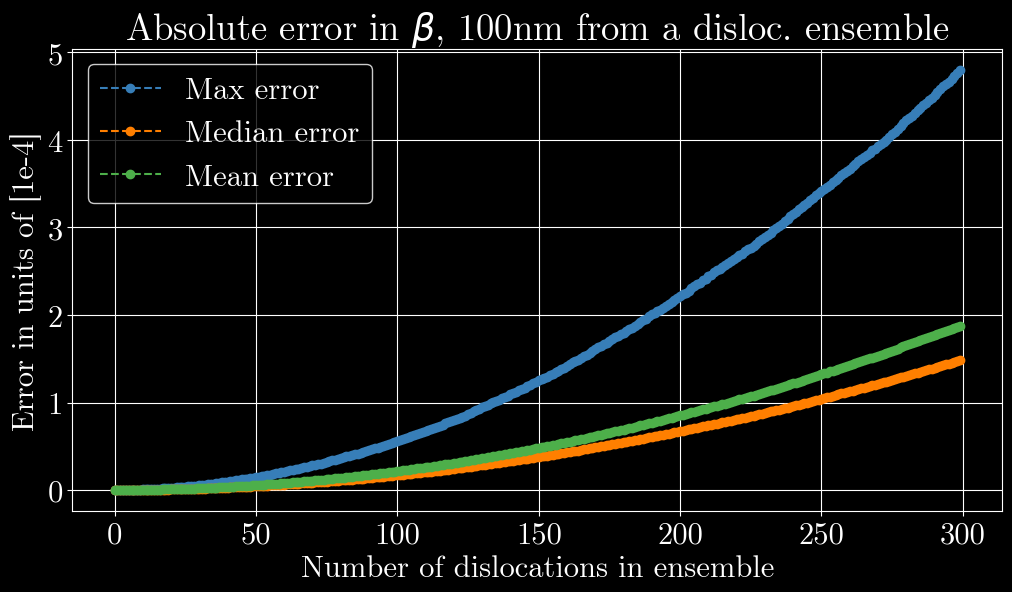

In [184]:
plt.figure(figsize=(12,6))
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
plt.plot(range(len(x0)), np.array(err)*1e4, 'o--', c=CB_color_cycle[0],  label='Max error')
plt.title(r'Absolute error in $\beta$, 100nm from a disloc. ensemble')
plt.plot(range(len(x0)), np.array(mederr)*1e4, 'o--' , c=CB_color_cycle[1], label='Median error')
plt.plot(range(len(x0)), np.array(meanerr)*1e4, 'o--' , c=CB_color_cycle[2], label='Mean error')
plt.legend()
plt.xlabel('Number of dislocations in ensemble')
plt.ylabel('Error in units of [1e-4]')
plt.grid(True)
plt.show()

In [189]:

xg = np.linspace(-0.05, 0.05, 256)
zg = np.array( [0])
Xgrid, Ygrid, Zgrid = np.meshgrid(xg, xg, zg, indexing="ij")
err = []

F = straight_edge_dislocation((Xgrid, Ygrid, Zgrid), x0 = (np.random.rand(300, 3)-0.5)*0.05)

beta_1 = F.copy().reshape(-1, 3, 3) - np.eye(3)
beta_1 = beta_1.reshape(Xgrid.shape + (3, 3))

H = np.linalg.inv(F.reshape(-1, 3, 3).transpose(0, 2, 1)) - np.eye(3)
beta_2 = -H.transpose(0, 2, 1)
beta_2 = beta_2.reshape(Xgrid.shape + (3, 3))

residual = beta_1 - beta_2

In [195]:
np.min(residual)

-6.196289696714604

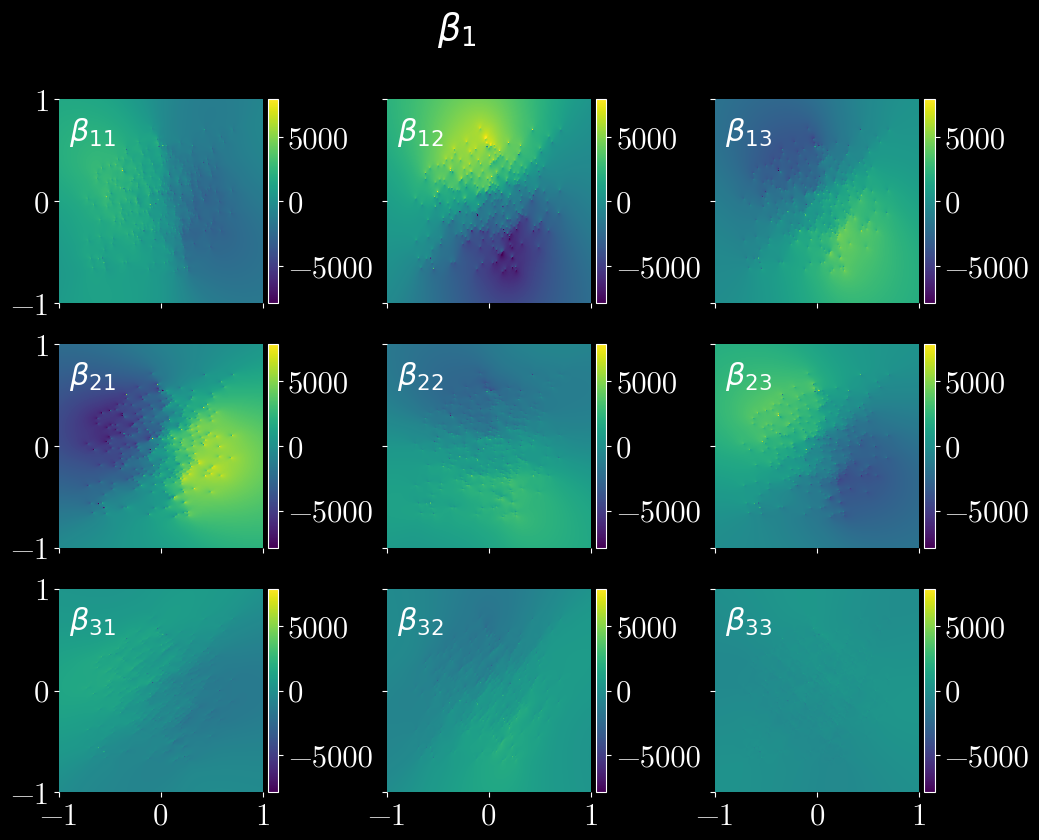

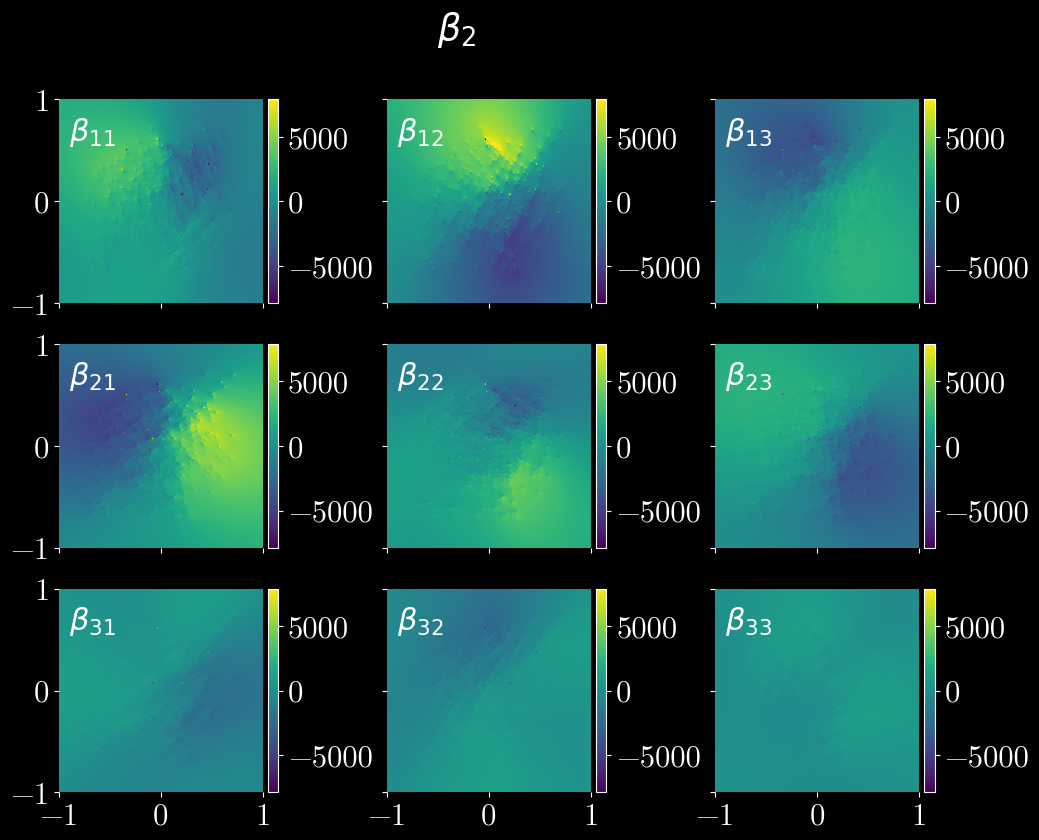

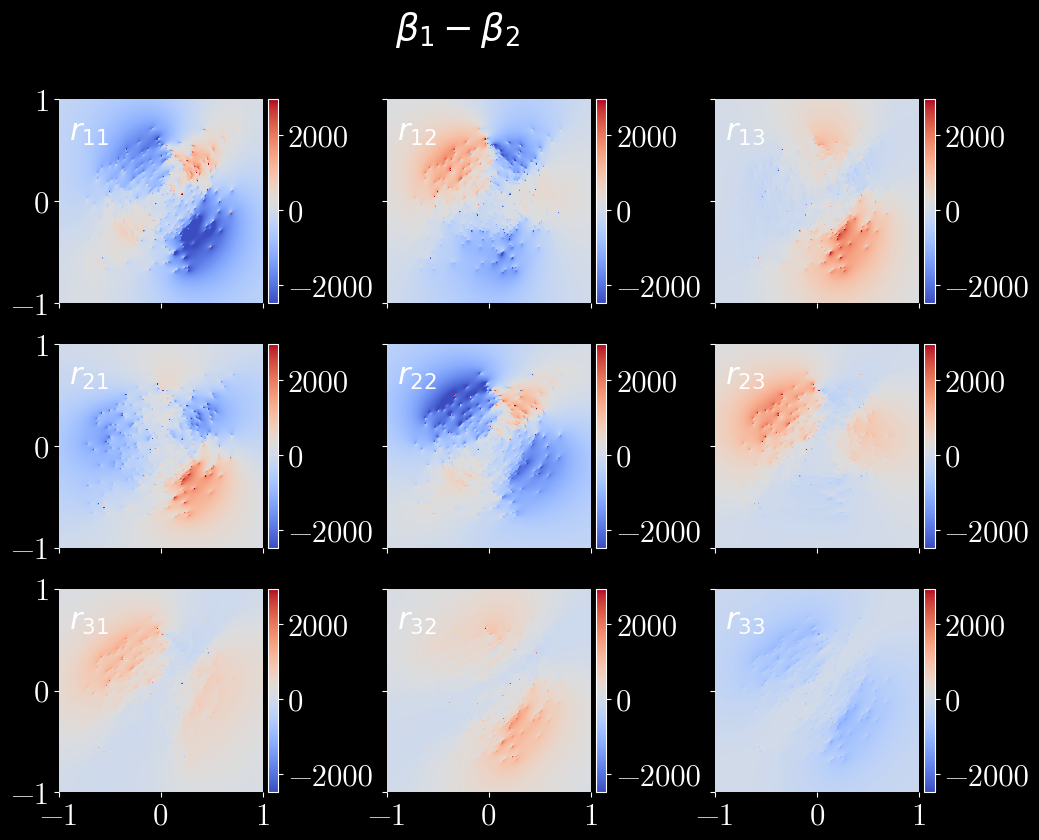

In [198]:
plt.style.use("dark_background")
vmax = np.max(beta_1) * 1e4 * 0.5
vmin = -np.abs(vmax)

titles = ["$\\beta_1$", "$\\beta_2$", "$\\beta_1 - \\beta_2$"]
cmaps = ["viridis", "viridis", "coolwarm"]
vmins = [vmin, vmin, np.min(residual) * 0.04* 1e4]
vmaxs = [vmax, vmax, np.max(residual) * 0.04* 1e4]

all_annotations = ( 
['$\\beta_{11}$',  '$\\beta_{12}$', '$\\beta_{13}$', '$\\beta_{21}$', '$\\beta_{22}$', '$\\beta_{23}$', '$\\beta_{31}$', '$\\beta_{32}$', '$\\beta_{33}$'],
 ['$\\beta_{11}$',  '$\\beta_{12}$', '$\\beta_{13}$', '$\\beta_{21}$', '$\\beta_{22}$', '$\\beta_{23}$', '$\\beta_{31}$', '$\\beta_{32}$', '$\\beta_{33}$'],
['$r_{11}$', '$r_{12}$', '$r_{13}$', '$r_{21}$', '$r_{22}$', '$r_{23}$', '$r_{31}$', '$r_{32}$', '$r_{33}$']
)

for field, cm, tit, vmin, vmax, annotations in zip(
    (beta_1, beta_2, residual), cmaps, titles, vmins, vmaxs, all_annotations
):
    fig, ax = plt.subplots(3, 3, figsize=(12, 9), sharex=True, sharey=True)
    fig.suptitle(tit)
    k=0
    for i in range(3):
        for j in range(3):
            
            im = ax[i, j].imshow(
                field[:, :, field.shape[2] // 2, i, j] * 1e4,
                origin="lower",
                extent=(-1, 1, -1, 1),
                vmin=vmin,
                vmax=vmax,
                cmap=cm,
            )
            ax[i,j].annotate(annotations[k], (-0.9,0.6), color='white', fontsize=22)
            k+=1
            fig.colorbar(im, ax=ax[i, j], fraction=0.046, pad=0.02)
    for a in ax.flatten():
        for spine in a.spines.values():
            spine.set_visible(False)
    plt.show()